In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import warnings 
warnings.filterwarnings('ignore')

In [107]:
sales = pd.read_csv('sales_train.csv')

In [4]:
item_cat = pd.read_csv('item_categories.csv') 
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [5]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [109]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [110]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [111]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [112]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [113]:
sales['date'] = pd.to_datetime(sales['date'].apply(lambda x: x.replace('.', '/')))

In [114]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [115]:
# Predict total sales in a month for the parent company( not the individual stores )
ts = sales.groupby('date_block_num')['item_cnt_day'].sum()

In [116]:
ts.head()

date_block_num
0    131479.0
1    128090.0
2    147142.0
3    107190.0
4    106970.0
Name: item_cnt_day, dtype: float64

Text(0, 0.5, 'Sales')

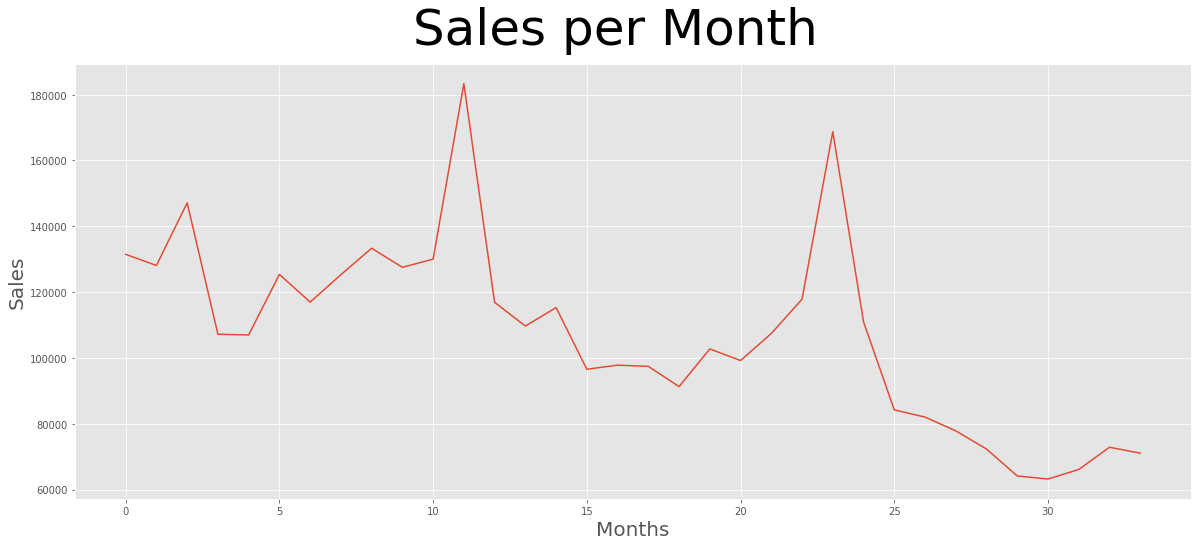

In [117]:
fig, ax= plt.subplots(1,1,figsize= (20,8))
fig.suptitle('Sales per Month', fontsize= 50)
plt.plot(ts)
plt.xlabel('Months', fontsize= 20)
plt.ylabel('Sales', fontsize= 20)

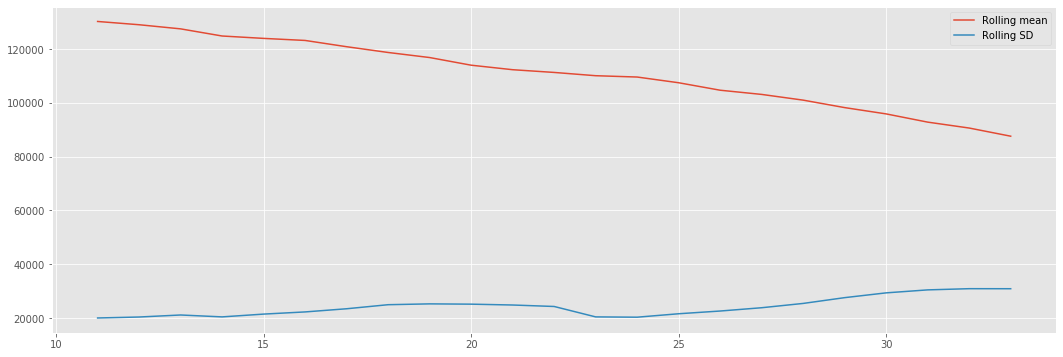

In [118]:
plt.figure(figsize= (18, 6))
plt.plot(ts.rolling(window= 12).mean(), label= 'Rolling mean')
plt.plot(ts.rolling(window= 12).std(), label= 'Rolling SD')
plt.legend()

In [119]:
# preidcit with arima model
# read heirarchical time series and use it with prophet
# All three type: bottom to top, middle out...
# Extensive feature engineering 
# ensemble model
# deep learning

In [120]:
# observations so far:
# decreasing trend
# An yearly seasonality present

In [121]:
# Lets check for stationarity now
# Three things for stationarity: constant mean, constant variance, constant autocorrelation
# Augmented Dicky fuller test, test only for trend stationarity
from statsmodels.tsa.stattools import adfuller

results = adfuller(ts)

In [122]:
print("Test statistics: %s"%results[0])
print('P-value of test: %s'%results[1])
print('Critical values of test statistics with p values: \n', results[4])

Test statistics: -2.3957040669944325
P-value of test: 0.1429525769929046
Critical values of test statistics with p values: 
 {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


Test statistics: -13.636220830132514
P-value of test: 1.686395122287309e-25
Critical values of test statistics with p values: 
 {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}


Text(0, 0.5, 'Sales')

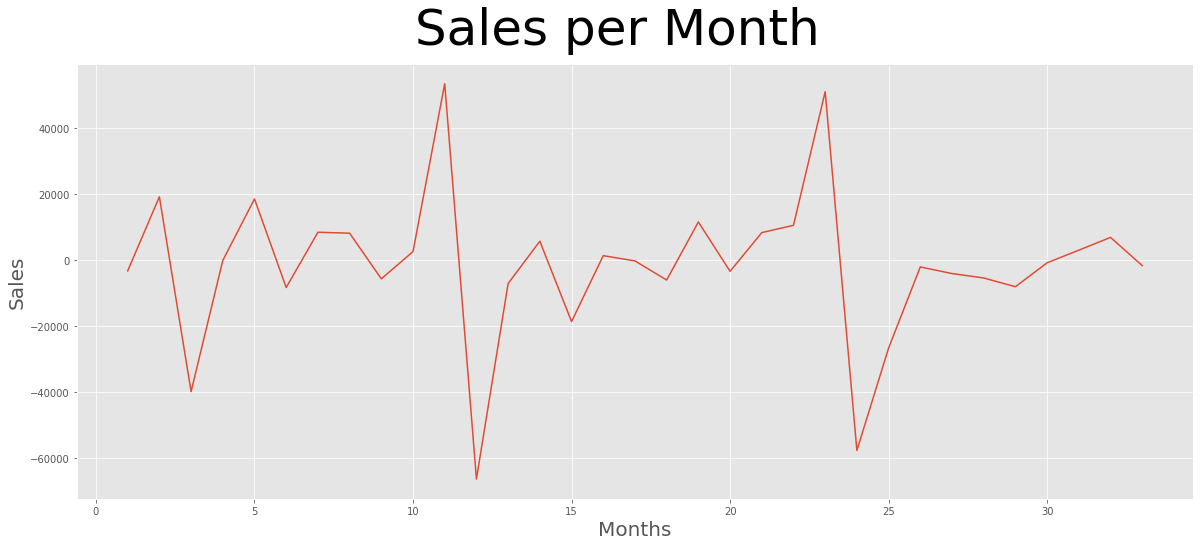

In [133]:
# Need p-values less than 0.05 to reject null hypothesis
# need to make our ts stationary
# common ways: Take difference(most common), log, sqrt, pct_change

new_ts = ts.diff().dropna()
# adfuller test
results = adfuller(new_ts)
print("Test statistics: %s"%results[0])
print('P-value of test: %s'%results[1])
print('Critical values of test statistics with p values: \n', results[4])

# plot diff ts
fig, ax= plt.subplots(1,1,figsize= (20,8))
fig.suptitle('Sales per Month', fontsize= 50)
plt.plot(new_ts)
plt.xlabel('Months', fontsize= 20)
plt.ylabel('Sales', fontsize= 20)

In [124]:
# only trend( constant mean) is taken care of and it passes adfuller test !!
# other requirements will be taken care of later
# Use sarimax model now
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARMA(2,1) model
model = SARIMAX(ts, order= (2, 1, 1))

In [125]:
results = model.fit()
forecast = results.get_forecast(steps= 10)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

conf_int

,lower item_cnt_day,upper item_cnt_day
34,32405.064256,117384.043987
35,24401.078489,130691.394802
36,19853.297826,139750.393666
37,17178.601698,146159.969931
38,15549.189286,150891.592944
39,14547.582277,154468.896026
40,13934.284233,157220.839094
41,13564.931733,159365.935288
42,13349.657341,161055.632897
43,13231.464961,162398.058058


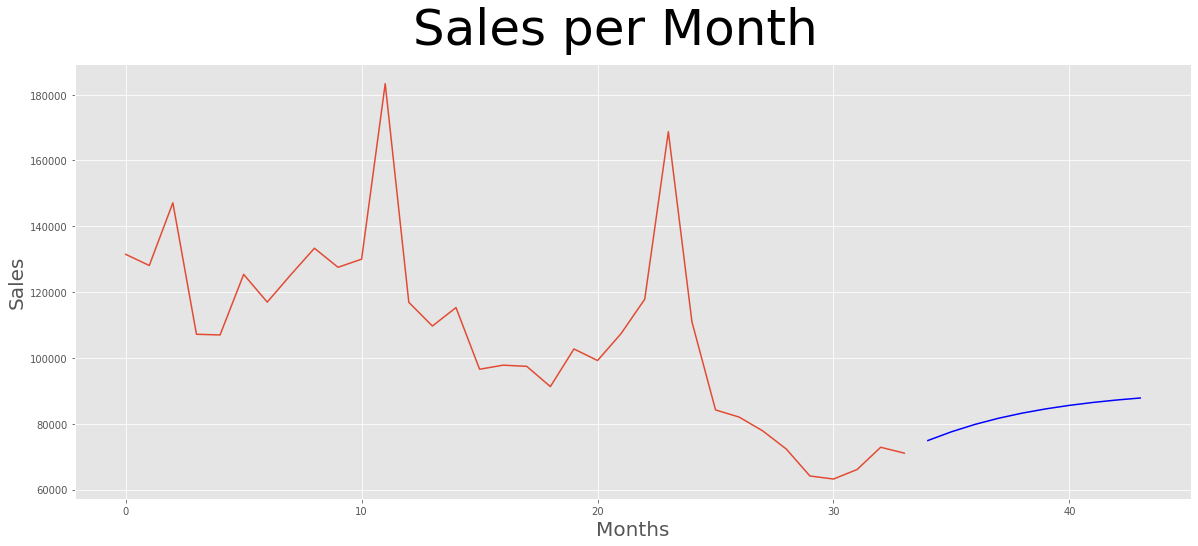

In [126]:
# plot forecast
fig, ax= plt.subplots(1,1,figsize= (20,8))
fig.suptitle('Sales per Month', fontsize= 50)
plt.plot(ts)
plt.xlabel('Months', fontsize= 20)
plt.ylabel('Sales', fontsize= 20)

ax.plot(mean_forecast.index, mean_forecast.values, color= 'blue', label= 'forecast')
#plt.fill_between(mean_forecast.index, conf_int['lower item_cnt_day'], conf_int['upper item_cnt_day'], color= 'lightblue')

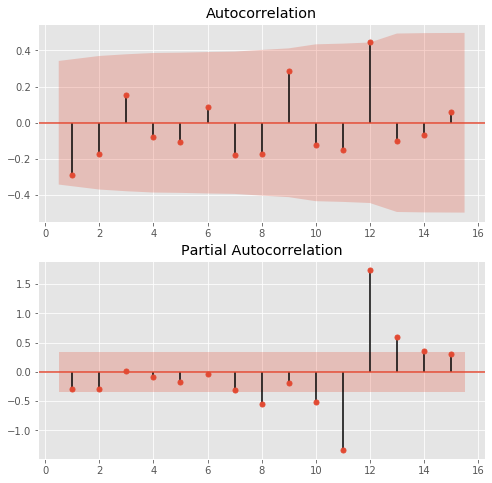

In [127]:
# Finding order of ARMA models
# plot ACF and PACF 
# ACF~tails off and PACF~cuts off after lag p -> AR(p) model
# PCAF~tails off and ACF~cuts off after lag q -> MA(q) model
# If ACF tails off very very slowly then the ts is not stationary and diff is required
# IF ACF is highly negative at lag 1 then we took too much diff 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (8,8))

plot_acf(new_ts, lags= 15, zero= False, ax= ax1)

plot_pacf(new_ts, lags= 15, zero= False, ax= ax2)
# no apparent pattern because we haven't eliminated seasonality
plt.show()

In [128]:
# Choosing best ARIMA model
# lower AIC better model
arima_order_aic = []

for p in range(5):
    for q in range(5):
        try:
            model = SARIMAX(ts, order= (p, 1, q))
        
            result = model.fit()
            arima_order_aic.append((p, q, result.aic))
        except:
            arima_order_aic.append((p, q, None))
            
aic_df = pd.DataFrame(arima_order_aic, columns= ['p', 'q', 'AIC'])
aic_df.sort_values('AIC')

,p,q,AIC
0,0,0,758.472453
1,0,1,758.684693
5,1,0,758.853470
6,1,1,759.827609
2,0,2,760.484902
10,2,0,760.777331
11,2,1,761.278530
7,1,2,761.541349
15,3,0,762.124642
3,0,3,762.877829


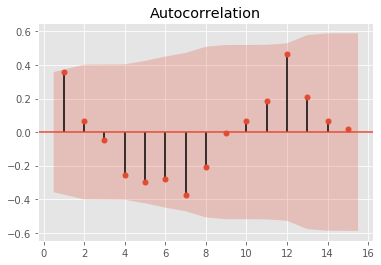

In [129]:
# Seasonality 
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_result = seasonal_decompose(ts, freq= 12)
# find frequency from ACF, its clear that there is a period of 12 months
# to make it more clear, do=> ts - ts.rolling(big num).mean(); as we want to find only period
plot_acf((ts - ts.rolling(5).mean()).dropna(), lags= 15, zero= False)
plt.show()

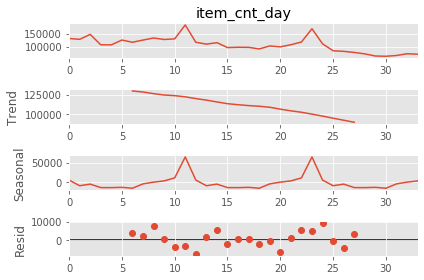

In [130]:
# this calculation detrend the series and make ACF more interpretable in terms of finding period
decomp_result.plot()
plt.show()

In [ ]:
# Now its time to fit a seasonal ts
# here we take two types of differencing , 'd' for fetrending and 'D' for de-seasoning
# we already know how to predict 'p' and 'q', only parameters left is 'P' and 'Q'
# to find them, we again use ACF and PACF but this time with multiple seasonal lags

new_ts = new_ts.diff(12).dropna()

In [137]:
# now left is model validation which is done using plot_diagnostic attribute of result

In [5]:
# there's a lib that does everything for us: pmdarima
df = pd.DataFrame({'cat':[1, 2, 1, 1, 2, 1, 2],
                  'values': [0, 324,54, 321, 567, 132, 789]})
print(df)
df.groupby('cat')['values'].transform('min')

   cat  values
0    1       0
1    2     324
2    1      54
3    1     321
4    2     567
5    1     132
6    2     789


0      0
1    324
2      0
3      0
4    324
5      0
6    324
Name: values, dtype: int64